In [1]:
"""
TBD need to know if position risk has been reduced, otherwise don't generate orders for symbol

Option 2:
    - Store initial_size and current_size of position
    - if current_size is some criteria below the initial size, then risk is reduced
    - filter out stocks where criteria is not met

Position Table Generation:
1. Each row in the position table shall obtain the following info:
    - Symbol name
    - initial size
    - entry date?
    - direction?
    -

Order Table Generation:
1.) Order Table generation shall follow this procedure:
    1. Retrieve data for current open positions
    2. For each open position:
        1. if at least one of the following is true:
            TRAIL_STOP || STOP || TARGET_EXIT || FRENCH_STOP || REGIME_END
            1. Generate an order entry, where type is the first discovered reason for entry creation
    3. For each symbol, create order entry if:
        symbol not in order_table && risk_reduced is True
    4.


Order Table Output:
1.) The following data shall be stored in the order_table, sorted by close type first. It may be a view of a larger table:
    Symbol,
    direction of trade,
    position size (dollars or shares),
    type: [
        ENTRY,
        TRAIL_STOP,
        STOP,
        TARGET_EXIT,
        FRENCH_STOP,
        REGIME_END
    ]


2.) Output of the order table shall be sorted by type, with the following priority:
    1. STOP
    2. TRAIL_STOP
    3. TARGET_EXIT
    4. FRENCH_STOP
    5. REGIME_END
    6. ENTRY



2.)
Entries/Exits in the order table shall be generated from
"""
import scripts
import data_manager.utils as sbtu
import tda_access.access as tda
import json
import scripts.account_data as sad
import tda_access.access as taa
import data_manager.utils as dmu
import pandas as pd
import pathlib
from data_manager import scanner

In [2]:
td_client = taa.TdBrokerClient.init_from_json('..\\data_args\\credentials.json')

In [3]:

# init client and tables
regime_df = pd.read_excel(pathlib.Path('..') / 'data' / 'regimes.xlsx')

with open('scanner_config.json') as fp:
    scanner_args = json.load(fp)

(
    website,
    start,
    end,
    vlty_n,
    dist_pct,
    retrace_pct,
    threshold,
    dgt,
    d_vol,
    r_vol,
    lvl,
    bm_ticker,
    bm_col,
    ccy_col,
    window,
    st,
    lt,
    save_ticker_df,
    save_last_row_df,
    save_regime_df
) = list(scanner_args.values())
fast = st
slow = lt
regime_cols = [
    'rg','rrg',
    'smaC'+str(st)+str(lt),'smar'+str(st)+str(lt), 'boHL'+str(slow),
    'borr'+str(slow),'ttH'+str(fast)+'L'+str(slow),'ttr'+str(fast)+'r'+str(slow)
]
groupby_cols = ['score', 'delta'] + regime_cols
sort_key = ['GICS Sub-Industry']
grouped = regime_df.groupby(sort_key)[groupby_cols].mean().sort_values(
    by= ['GICS Sub-Industry','score'])

# delta is the diff between absolute and relative regime scores
delta_bound = 0.5
sub_sectors = list(grouped.loc[
    ((grouped.delta >= delta_bound) & (grouped.rrg > 0)) |
    ((grouped.delta <= -delta_bound) & (grouped.rrg < 0))
].index)
watch_stocks = regime_df.loc[
    (regime_df['GICS Sub-Industry'].isin(sub_sectors)) &
    (regime_df['rrg'] * grouped['delta'].loc[regime_df['GICS Sub-Industry']].values > 0)
    , 'Symbol'
]


In [4]:
_strategy_lookup, tx_tables, price_histories, bench = sad.main(
    td_client=td_client,
    sub_sectors= [],
    symbols=['FRC'] + list(watch_stocks)
)

BALL
FRC
KMI
NEM
OKE
TAP
TMUS
WMB
d


In [5]:
order_table = pd.read_excel(pathlib.Path('..') / 'data' / 'order_table.xlsx', index_col=0)

In [6]:
order_table

,symbol,stop_px,en_px,r_pct,target,shares,en_px_abs,GICS Sub-Industry,nominal_size,clamped_shares
0,BALL,51.056246,52.981703,0.036342,55.869889,97,53.18,"Metal, Glass & Plastic Containers",5158.46,97
1,FRC,14.429479,13.359997,-0.080051,11.755775,-173,13.41,Regional Banks,-2319.93,-174
2,KMI,16.929844,17.643963,0.040474,18.715142,260,17.71,Oil & Gas Storage & Transportation,4604.60,260
3,NEM,53.572646,51.875842,-0.032709,49.330638,-109,52.07,Gold,-5675.63,-110
4,OKE,68.930052,65.743938,-0.048462,60.964767,-58,65.99,Oil & Gas Storage & Transportation,-3827.42,-59
5,TAP,52.766855,51.387670,-0.026839,49.318891,-134,51.58,Brewers,-6911.72,-135
6,TMUS,150.667515,148.563964,-0.014159,145.408638,-88,149.12,Wireless Telecommunication Services,-13122.56,-89
7,WMB,31.001448,29.828360,-0.039328,28.068729,-157,29.94,Oil & Gas Storage & Transportation,-4700.58,-158


In [7]:
symbol = 'BALL'
od = order_table[order_table.symbol == symbol]

In [8]:
epd = _strategy_lookup[symbol].enhanced_price_data.copy()

In [9]:
_pt = _strategy_lookup[symbol].peak_table.copy()
# _pt = pda.PeakTable(_pt)
# _pt = _pt.unpivot(_symbol_data.index)
# _pt = _pt.loc[~_pt.index.duplicated(keep='first')]
def filter_duplicates(_sw):
    return _sw.loc[~_sw.index.duplicated(keep='first')]

_shi_px = _pt.loc[(_pt.type == -1)].set_index('end')
_slo_px = _pt.loc[(_pt.type == 1)].set_index('end')
_shis = []
_slos = []
for i in range(1, 5):
    _shis.append(
        _shi_px.loc[(_shi_px.lvl == i)]
    )
    _shis[i-1] = filter_duplicates(_shis[i-1])
    _slos.append(
        _slo_px.loc[(_slo_px.lvl == i)]
    )
    _slos[i-1] = filter_duplicates(_slos[i-1])
    epd[f'hi{i}_lag'] = _shis[i-1].en_px
    epd[f'lo{i}_lag'] = _slos[i-1].en_px

epd['hi_band'] = epd.close.rolling(256).max()
epd['lo_band'] = epd.close.rolling(256).min()
epd['trade_range'] = epd.hi_band - epd.lo_band
epd['40pct_band'] = epd.trade_range * .4 + epd.lo_band
epd['61pct_band'] = epd.trade_range * .61 + epd.lo_band

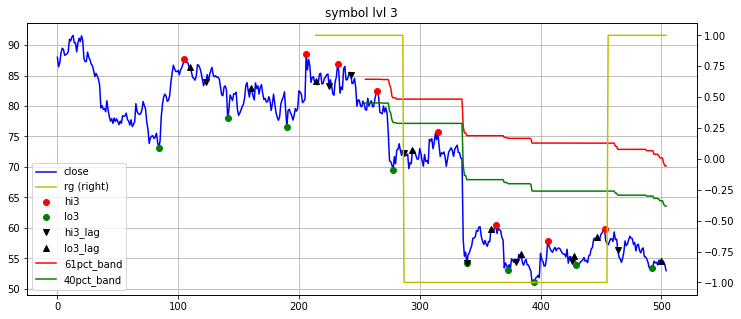

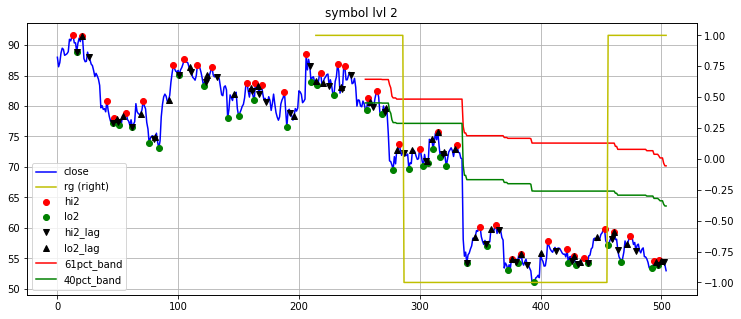

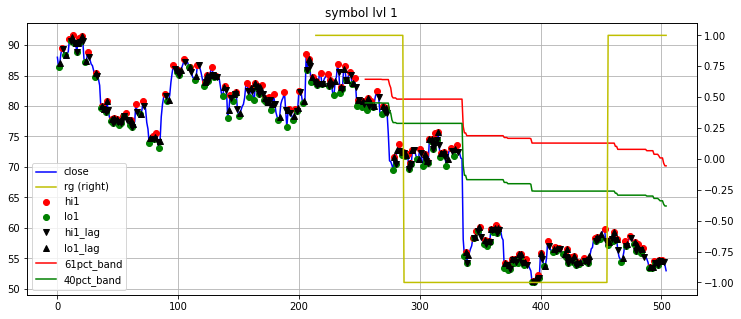

In [11]:
def plot(lvl):
    epd[[
        'close',
        'rg',
        f'hi{lvl}',
        f'lo{lvl}',
        f'hi{lvl}_lag',
        f'lo{lvl}_lag',
        '61pct_band',
        '40pct_band'
    ]].plot(
        style=[
            'b',
            'y',
            'ro',
            'go',
            'kv',
            'k^',
            'r-',
            'g-'
        ], figsize=[12, 5], secondary_y='rg', grid=True, title=f'symbol lvl {lvl}')

# plot(4)
plot(3)
plot(2)
plot(1)